In [2]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter

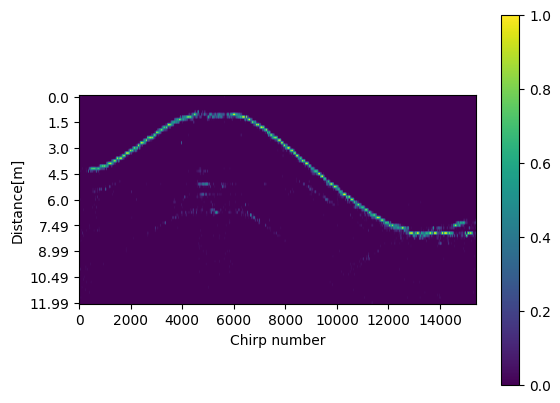

In [9]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.ndimage import median_filter

from source.helper import to_dB, print_spectogram, gen_spectogram, diff_frames

BASE_DIR = Path("E:/radar-project/data")  # change to your project dir

loaded_file = h5py.File(BASE_DIR / 'complete_dataset.h5', 'r')

sample_file = loaded_file['2023_03_21']['chodzonko_1os_4-1-8m_bartek']
sample_file = sample_file[:, 0, 0, :]
normal_spect, y = gen_spectogram(sample_file)
normal_spect = to_dB(normal_spect)
frames_diff = diff_frames(sample_file, 1)
diff_spect, y = gen_spectogram(frames_diff)
diff_spectdb = to_dB(diff_spect)
smoothed_array = median_filter(diff_spectdb, size=(1, 500), mode='constant')
tresholded = np.zeros_like(smoothed_array)
max_indices = np.argmax(diff_spectdb, axis=0)
tresholded[max_indices, np.arange(diff_spectdb.shape[1])] = 1
print_spectogram(tresholded, y, depth_limit=12)

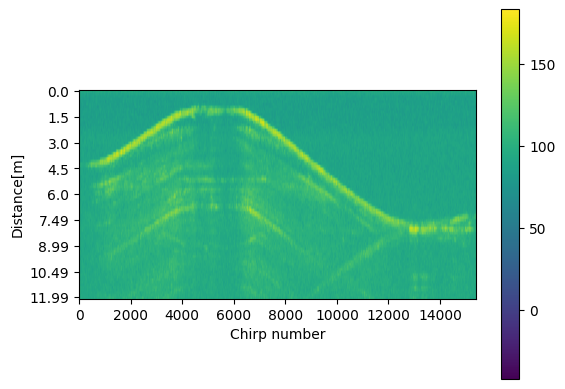

In [10]:
print_spectogram(diff_spectdb, y, depth_limit=12)

In [20]:
from tqdm import tqdm
# Create a Kalman filter with state space dimension of 256 and observation dimension of 256
kf = KalmanFilter(dim_x=90, dim_z=90)

# Define the state transition matrix, assuming a constant velocity model
dt = 1.0  # time step
kf.F = dt * np.eye(90, k=1)  # state transition matrix
kf.Q = np.eye(90) * 10e-1  # process noise covariance matrix

# Define the observation matrix
kf.H = np.eye(90)

# Define the measurement noise covariance matrix
kf.R = np.eye(90) * 10e-1

filtered_data = np.zeros((90, 15394))

input_data = diff_spectdb[:90, :]
# iterate over each time step
state_estimate = np.zeros((90, 1))
P = np.eye(90)*1

for t in tqdm(range(15394)):
# Initialize the state estimate and error covariance matrix
    # Define the measurement as the current column of the data array
    measurement = input_data[:, t].reshape(-1, 1)

    # Predict the state estimate and error covariance matrix using the state transition matrix and process noise covariance matrix
    kf.predict(state_estimate, P)

    # Update the state estimate and error covariance matrix using the measurement, observation matrix, and measurement noise covariance matrix
    kf.update(measurement)

    filtered_data[:, t] = kf.x.reshape(-1)

100%|██████████| 15394/15394 [01:05<00:00, 233.84it/s]


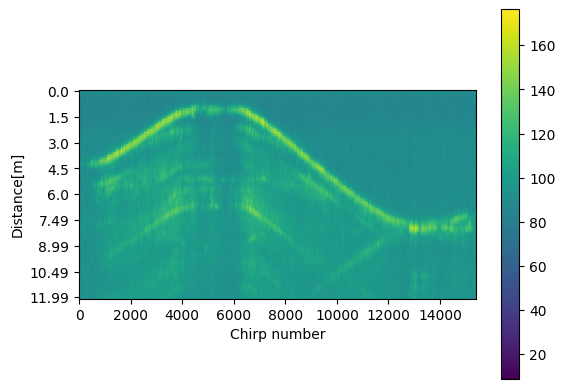

In [21]:
print_spectogram(filtered_data, y, depth_limit=12)

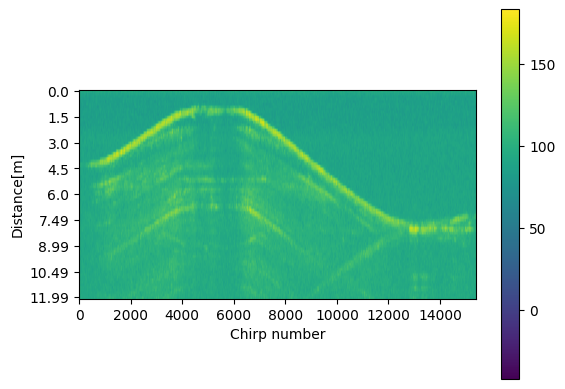

In [22]:
print_spectogram(diff_spectdb, y, depth_limit=12)

In [109]:
kf = KalmanFilter(dim_x=2, dim_z=1)

# Define the state transition matrix
dt = 1.0  # time step
kf.F = np.array([[1, dt], [0, 1]])

# Define the measurement function matrix
kf.H = np.array([[1, 0]])

# Define the process noise covariance matrix
q = 10e-15  # process noise
kf.Q = np.array([[q * dt ** 3 / 3, q * dt ** 2 / 2],
                 [q * dt ** 2 / 2, q * dt]])

# Define the measurement noise covariance matrix
r = 1  # measurement noise
kf.R = np.array([[r]])

# Define the initial state and covariance matrix
x0 = np.array([0, 0])  # initial state (position, velocity)
p0 = np.eye(2)  # initial covariance matrix

# Initialize the filter with the initial state and covariance matrix
kf.x = x0
kf.P = p0

positions = np.zeros((15394, 1))
max_indices = np.argmax(diff_spectdb[:90, :], axis=0)
input_data = max_indices[:,np.newaxis]
for t in tqdm(range(15394)):
# Initialize the state estimate and error covariance matrix
    # Define the measurement as the current column of the data array

    z = np.array([input_data[t]])  # measurement at time i
    kf.predict()
    kf.update(z)
    positions[t] = kf.x[0]

100%|██████████| 15394/15394 [00:01<00:00, 15332.68it/s]


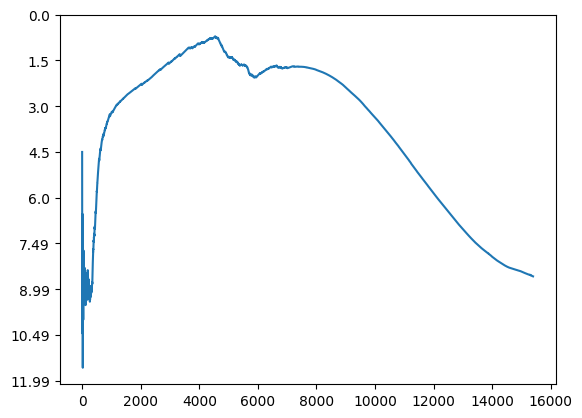

In [110]:
plt.plot(np.flip(positions, axis=1))
plt.yticks(np.arange(start=0, stop=81, step=10), y[:81:10])
plt.gca().invert_yaxis()
plt.show()

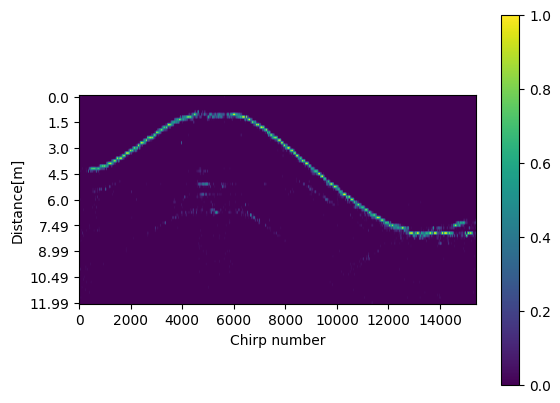

In [78]:
print_spectogram(tresholded, y, depth_limit=12)